### Deep NN to fit the Poly8 model of AA6016-T4 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import ysnnutil as yut
nb='nb14'
wFile='./'+nb+'_fitPolyN8'

2023-06-11 05:19:41.420167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-11 05:19:41.420226: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
### Aluminum alloy AA6016-T4 Poly8 model
vCoeff=[1.0,-2.7575360419397117,11.530135957809993,-25.895206461605195,34.38295306726676,-27.913685793880834,13.264500537932427,
-3.4446490737696935,1.1470222893313808,19.694927566274288,-22.728141338803983,97.14527508865311,-118.15219232701236,
79.56140212110728,-22.863865241214093,26.876869442462294,72.53986457067393,-76.33248924405487,263.73730517826544,
-61.653927738263796,77.5711377175994,144.52991577535954,-151.25820450588395,144.06559886753368,77.06411729917284]
deg=8
maxSXY=1.0/(vCoeff[-1]**(1.0/deg))
vCoeff=yut.PolyNparam(deg,vCoeff)

## Generate data
vPoints=yut.genSpherePoints(100)
nPoints=vPoints.shape[0]
print('Number of data points = ',nPoints)
for k in range(nPoints):
    rho=yut.fYF(vPoints[k,0],vPoints[k,1],vPoints[k,2],vCoeff)
    vPoints[k,:]=vPoints[k,:]/rho   

Number of data points =  6512


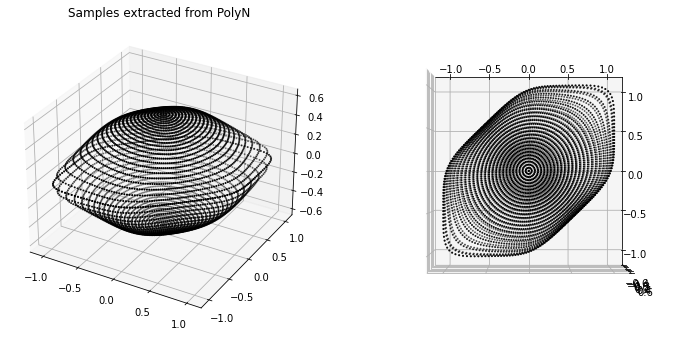

In [3]:
fg=plt.figure(figsize=(12,25))
axa=fg.add_subplot(1,2,1,projection='3d')
axa.scatter(vPoints[:,0],vPoints[:,1],vPoints[:,2],marker='o',color='k',s=1)
axa.set_title("Samples extracted from PolyN")
axb=fg.add_subplot(1,2,2,projection='3d')
axb.scatter(vPoints[:,0],vPoints[:,1],vPoints[:,2],marker='o',color='k',s=1)
axb.azim=270;axb.elev=90
plt.show()

In [4]:
### Scramble the data and generate targets
np.random.seed(99)
pp=np.random.permutation(nPoints)
vPoints[:]=vPoints[pp[:]]
vTargets=np.ones((nPoints,1))

In [5]:
import os,random
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
gseed=99
np.random.seed(gseed)
random.seed(gseed)
os.environ['PYTHONHASHSEED']=str(gseed)

from keras import backend as K
if(1):
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    tf.random.set_seed(gseed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

2023-06-11 05:19:49.825269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-11 05:19:49.825335: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-11 05:19:49.825364: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e5422e2a8436): /proc/driver/nvidia/version does not exist


In [24]:
def pwAct2(x):
    return x**2
def pwAct8(x):
    return x**8
    #return tf.math.maximum(0.0,x)
def pwAct10(x):
    return x**10    

opt=keras.optimizers.RMSprop(learning_rate=0.0001)
mmval=0.8
nun1=27
model=keras.Sequential()
model.add(layers.Dense(nun1,activation=pwAct10,use_bias=False,
             #kernel_initializer=keras.initializers.RandomUniform(minval=-mmval, maxval=mmval, seed=gseed),
             kernel_initializer=keras.initializers.GlorotUniform(gseed),
             kernel_regularizer=keras.regularizers.L2(l2=1e-6)))
#model.add(layers.Dense(nun2,activation=pwAct2,use_bias=False,
#             #kernel_initializer=keras.initializers.RandomUniform(minval=-mmval, maxval=mmval, seed=gseed),
#             kernel_initializer=keras.initializers.GlorotUniform(gseed+1), 
#             kernel_constraint=keras.constraints.NonNeg(),
#             kernel_regularizer=keras.regularizers.L2(l2=1e-6)))

model.add(layers.Dense(1,use_bias=False,
             kernel_initializer=keras.initializers.Ones(),
             trainable=False
             #kernel_initializer=keras.initializers.RandomUniform(minval=-mmval, maxval=mmval, seed=gseed),
             #kernel_initializer=keras.initializers.GlorotUniform(gseed+4),
             #kernel_constraint=keras.constraints.NonNeg(),          
             #kernel_regularizer=keras.regularizers.L2(l2=1e-6)))
                      ))

model.compile(optimizer=opt,loss=keras.losses.MeanSquaredError(),metrics=["accuracy"])    
#keras.utils.set_random_seed(99)
np.random.seed(gseed)
random.seed(gseed)
tf.random.set_seed(gseed)
history=model.fit(
vPoints,
vTargets,
epochs=300,
batch_size=16,
#batch_size=nPoints,
validation_data=()
)

Epoch 1/300
407/407 [==============================] - 1s 1ms/step - loss: 0.9933 - accuracy: 0.0000e+00
Epoch 2/300
407/407 [==============================] - 1s 1ms/step - loss: 0.9863 - accuracy: 0.0000e+00
Epoch 3/300
407/407 [==============================] - 0s 1ms/step - loss: 0.9735 - accuracy: 0.0046
Epoch 4/300
407/407 [==============================] - 0s 1ms/step - loss: 0.9538 - accuracy: 0.0147
Epoch 5/300
407/407 [==============================] - 0s 1ms/step - loss: 0.9361 - accuracy: 0.0223
Epoch 6/300
407/407 [==============================] - 0s 1ms/step - loss: 0.9182 - accuracy: 0.0278
Epoch 7/300
407/407 [==============================] - 0s 1ms/step - loss: 0.8918 - accuracy: 0.0313
Epoch 8/300
407/407 [==============================] - 0s 1ms/step - loss: 0.8502 - accuracy: 0.0346
Epoch 9/300
407/407 [==============================] - 1s 1ms/step - loss: 0.7900 - accuracy: 0.0416
Epoch 10/300
407/407 [==============================] - 0s 1ms/step - loss: 0.7081 

i =  0  sxy =  0.0
i =  1  sxy =  0.11619126222633623
i =  2  sxy =  0.17428689333950434
i =  3  sxy =  0.23238252445267246
i =  4  sxy =  0.29047815556584056
i =  5  sxy =  0.3485737866790087
i =  6  sxy =  0.40666941779217675
i =  7  sxy =  0.4647650489053449
i =  8  sxy =  0.522860680018513
i =  9  sxy =  0.5664324033533891
i =  10  sxy =  0.5751467480203643
i =  11  sxy =  0.5797943985094177


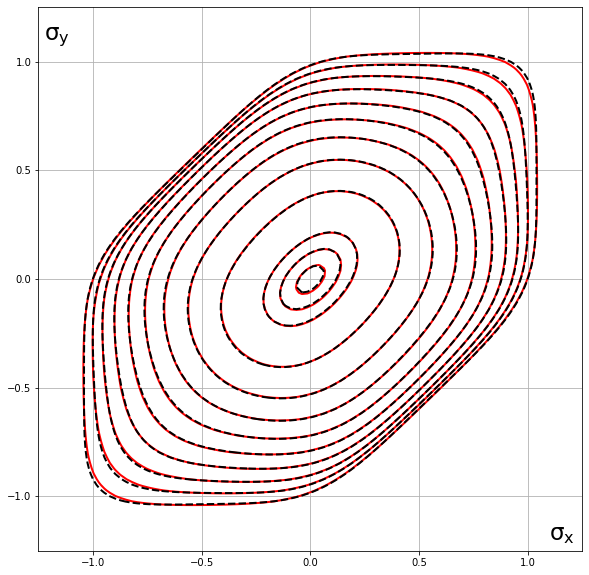

In [25]:
npt=100
vsx=np.linspace(-1.25,1.25,npt)
vsy=np.linspace(-1.25,1.25,npt)
###maxSXY=0.5
#vsxy=[0.0]
vsxy=maxSXY*np.array([0.0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.975,0.99,0.998])
X,Y=np.meshgrid(vsx,vsy)
npt2=npt*npt
X,Y=X.reshape((npt2,1)),Y.reshape((npt*npt,1))
vp=np.zeros((npt*npt,3))
vp[:,0]=X[:,0];vp[:,1]=Y[:,0]
vzPoly=np.zeros((npt2,1))
fg2=plt.figure(figsize=(10,10))
ax2=fg2.add_subplot()
for ii,sxy in enumerate(vsxy):
    vp[:,2]=sxy
    vz=model(vp)
    for kk in range(npt2):
        vzPoly[kk,0]=yut.fYF(vp[kk,0],vp[kk,1],vp[kk,2],vCoeff)
    print('i = ',ii, ' sxy = ',sxy)
    ax2.contour(vsx,vsy,tf.reshape(vz,(npt,npt)),levels=[1.0],linewidths=2,colors=['r'])
    ax2.contour(vsx,vsy,vzPoly.reshape((npt,npt)),levels=[1.0],linewidths=2,linestyles='--',colors=['k'])
    #vz2=vTerms[0]**(1.0/degree);print(np.max(vz-vz2),np.min(vz-vz2))
    #ax.contour(vsx,vsy,vz2,levels=[1.0],linewidths=1,colors=['r'])
ax2.grid()
ax2.set_aspect('equal')
y1,y2=ax2.get_ylim()
ax2.text(x=1.1,y=y1+0.02*(y2-y1),s=r'$\mathregular{\sigma_{x}}$',fontsize=23)
x1,x2=ax2.get_xlim()
ax2.text(x=x1+0.01*(x2-x1),y=1.1,s=r'$\mathregular{\sigma_{y}}$',fontsize=23)
plt.show()

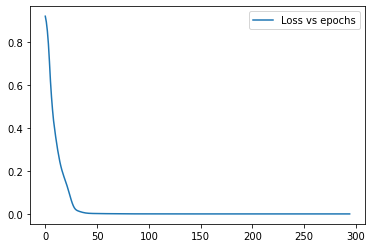

In [26]:
##print(len(history.history['loss']))
fhst=plt.figure()
ax=fhst.add_subplot()
ax.plot(history.history['loss'][5:], label='Loss vs epochs')
ax.legend()
plt.show()

In [27]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 27)                81        
                                                                 
 dense_9 (Dense)             (None, 1)                 27        
                                                                 
Total params: 108
Trainable params: 81
Non-trainable params: 27
_________________________________________________________________


In [28]:
vw=model.get_weights()
#dir(vw)
print('number of layers: ',len(vw))
print('first layer weight matrix: ',vw[0].shape)
print('second layer weight matrix: ',vw[1].shape)

number of layers:  2
first layer weight matrix:  (3, 27)
second layer weight matrix:  (27, 1)


In [29]:
model.save_weights(wFile, overwrite=True, save_format='tf', options=None)